Epoch 1/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 135s 208ms/step - accuracy: 0.7069 - loss: 0.5320 - val_accuracy: 0.8744 - val_loss: 0.3070
Epoch 2/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 134s 196ms/step - accuracy: 0.8988 - loss: 0.2517 - val_accuracy: 0.8630 - val_loss: 0.3418
Epoch 3/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 132s 211ms/step - accuracy: 0.9327 - loss: 0.1748 - val_accuracy: 0.8376 - val_loss: 0.4759


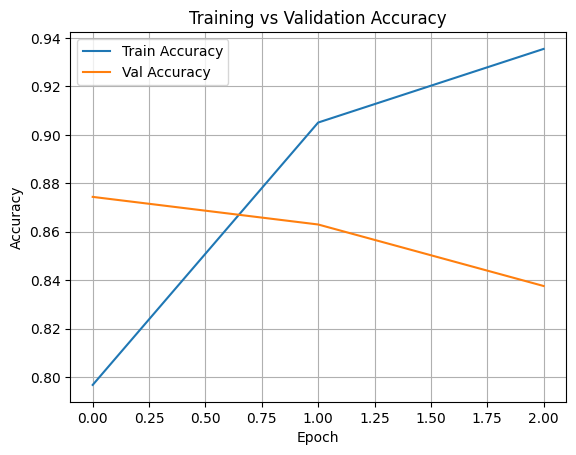

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

# ✅ 1. Load and preprocess IMDB dataset
def preprocess_dataset():
    (train_data, val_data), ds_info = tfds.load(
        'imdb_reviews',
        split=['train[:80%]', 'train[80%:]'],
        as_supervised=True,
        with_info=True
    )

    # Vectorize text
    vectorizer = tf.keras.layers.TextVectorization(max_tokens=10000, output_sequence_length=200)
    text_ds = train_data.map(lambda x, y: x)
    vectorizer.adapt(text_ds)

    train = train_data.map(lambda x, y: (vectorizer(x), y)).batch(32).prefetch(tf.data.AUTOTUNE)
    val = val_data.map(lambda x, y: (vectorizer(x), y)).batch(32).prefetch(tf.data.AUTOTUNE)

    return train, val, vectorizer.vocabulary_size()

train_data, val_data, vocab_size = preprocess_dataset()

# ✅ 2. Custom Positional Embedding Layer
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim):
        super().__init__()
        self.token_embed = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_embed = layers.Embedding(input_dim=sequence_length, output_dim=embed_dim)
        self.sequence_length = sequence_length

    def call(self, x):
        positions = tf.range(start=0, limit=self.sequence_length, delta=1)
        embedded_tokens = self.token_embed(x)
        embedded_positions = self.pos_embed(positions)
        return embedded_tokens + embedded_positions

# ✅ 3. Transformer encoder block
def transformer_encoder(x, embed_dim, num_heads, ff_dim, dropout=0.1):
    attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
    x = layers.Add()([x, attention])
    x = layers.LayerNormalization()(x)

    ffn = layers.Dense(ff_dim, activation="relu")(x)
    ffn = layers.Dense(embed_dim)(ffn)
    x = layers.Add()([x, ffn])
    x = layers.LayerNormalization()(x)

    return x

# ✅ 4. Build model
def build_model():
    inputs = layers.Input(shape=(200,), dtype=tf.int32)
    x = PositionalEmbedding(200, vocab_size=vocab_size, embed_dim=64)(inputs)
    x = transformer_encoder(x, embed_dim=64, num_heads=2, ff_dim=128)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# ✅ 5. Train
model = build_model()
history = model.fit(train_data, validation_data=val_data, epochs=3)

# ✅ 6. Plot
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()
